## Machine Learning II - Uso de XGBoost e K-Means para uma análise de E-commerce

**Realizado por:**
Artur Stein - 1116023

#### Sobre o Conjunto de Dados

O conjunto de dados selecionado para este trabalho é baseado em dados reais da empresa de e-commerce *Olist*, que é uma empresa brasileira que oferece soluções para lojistas venderem seus produtos em marketplaces de forma integrada. Fundada em 2015, a plataforma permite que pequenos e médios comerciantes ampliem seu alcance e eficiência de vendas online. O *Olist* cuida de todo o processo, desde a integração dos produtos até o suporte ao cliente, facilitando a gestão de vendas multicanal. A empresa se destaca por democratizar o acesso ao e-commerce, ajudando empreendedores a crescer no mercado digital.

Os dados podem ser encontrados no [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).


#### Objetivos

O objetivo deste trabalho é aplicar os conhecimentos adquiridos no módulo de Machine Learning II, por meio da:
- Utilização de um método de *Ensemble* para classificar a satisfação dos clientes; 
- Utilização de um método de *Clustering* para agrupar clientes com base em dados RFM.

### Importando as Bibliotecas

In [67]:
## Algumas funções terão mudanças futuras no seu funcionamento, podendo levar a mau funcionamento, gerando avisos, mas para uma melhor leitura, esses avisos serão removidos.
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from xgboost import XGBClassifier

### Carregando os Dados

In [69]:
customers_df= pd.read_csv('olist_customers_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv')
items_df= pd.read_csv('olist_order_items_dataset.csv')
payments_df= pd.read_csv('olist_order_payments_dataset.csv')
reviews_df= pd.read_csv('olist_order_reviews_dataset.csv')
products_df= pd.read_csv('olist_products_dataset.csv')
sellers_df= pd.read_csv('olist_sellers_dataset.csv')

### Análises Iniciais

In [70]:
datasets = [customers_df, items_df, payments_df, orders_df, reviews_df, products_df, sellers_df]
titles = ['customers', 'items', 'payments', 'reviews', 'orders', 'products', 'sellers']

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['colunas'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_linhas']= [data.shape[0] for data in datasets]
data_summary['total_colunas']= [data.shape[1] for data in datasets]
data_summary['total_duplicados']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['colunas_null'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,colunas,total_linhas,total_colunas,total_duplicados,total_null,colunas_null
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
2,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
3,reviews,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
4,orders,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,


O dataset apresenta diversos registros nulos, que serão tratados durante o decorrer do projeto.

In [71]:
df= pd.merge(customers_df, orders_df, on='customer_id', how='inner')
df= df.merge(reviews_df, on='order_id', how='inner')
df= df.merge(items_df, on='order_id', how='inner')
df= df.merge(products_df, on='product_id', how='inner')
df= df.merge(payments_df, on='order_id', how='inner')
df= df.merge(sellers_df, on='seller_id', how='inner')
df.shape

(117329, 39)

In [72]:
df.describe()

,customer_zip_code_prefix,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix
count,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000,115634.000000,115634.000000,115634.000000,117309.000000,117309.000000,117309.000000,117309.000000,117329.000000,117329.000000,117329.000000,117329.000000
mean,35060.118112,4.031467,1.194121,120.524349,20.027514,48.768018,785.802861,2.205528,2110.763062,30.254456,16.612476,23.071452,1.094452,2.940151,172.062565,24450.781955
std,29849.496175,1.387927,0.684225,182.944843,15.828077,10.033831,652.382965,1.717783,3785.128931,16.177519,13.452625,11.745875,0.731174,2.775370,265.388194,27582.364358
min,1003.000000,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1001.000000
25%,11250.000000,4.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.750000,6429.000000
50%,24240.000000,5.000000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.100000,13660.000000
75%,58770.000000,5.000000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.060000,28035.000000
max,99990.000000,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99730.000000


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117329 non-null  object 
 1   customer_unique_id             117329 non-null  object 
 2   customer_zip_code_prefix       117329 non-null  int64  
 3   customer_city                  117329 non-null  object 
 4   customer_state                 117329 non-null  object 
 5   order_id                       117329 non-null  object 
 6   order_status                   117329 non-null  object 
 7   order_purchase_timestamp       117329 non-null  object 
 8   order_approved_at              117314 non-null  object 
 9   order_delivered_carrier_date   116094 non-null  object 
 10  order_delivered_customer_date  114858 non-null  object 
 11  order_estimated_delivery_date  117329 non-null  object 
 12  review_id                     

### Pré-processamento dos dados

In [74]:
df.isna().sum()[:20]

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1235
order_delivered_customer_date      2471
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             103437
review_comment_message            67650
review_creation_date                  0
review_answer_timestamp               0
order_item_id                         0
product_id                            0
dtype: int64

In [75]:
df.dropna(subset= ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'], inplace=True)

In [76]:
df.isna().sum()[20:]

seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name         1625
product_name_lenght           1625
product_description_lenght    1625
product_photos_qty            1625
product_weight_g                20
product_length_cm               20
product_height_cm               20
product_width_cm                20
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
dtype: int64

In [77]:
df.dropna(subset= ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

In [78]:
df.isnull().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             101242
review_comment_message            66750
review_creation_date                  0
review_answer_timestamp               0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name              1606


Removemos maior parte dos nulos, o restante será retirado mais pra frente.

In [79]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])

In [80]:
df['estimated_days'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

In [81]:
df['arrival_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [82]:
df['shipping_days'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']).dt.days

In [83]:
df.drop((df[['order_delivered_carrier_date', 'order_delivered_customer_date']][df.shipping_days < 0]).index, inplace= True)

Foram adicionadas três novas colunas relacionadas às entregas dos pedidos, a saber:

- **Estimated_Days:** Indica o número de dias corridos entre a compra do pedido e sua entrega estimada.
- **Arrival_Days:** Refere-se ao número de dias corridos entre a compra do pedido e sua entrega ao cliente.
- **Shipping_Days:** Representa o número de dias corridos entre a postagem do pedido e sua entrega ao cliente.

Essas informações recém-incorporadas serão utilizadas para análises e como *features* em nosso modelo.

In [84]:
df[['estimated_days', 'arrival_days', 'shipping_days']].describe()

,estimated_days,arrival_days,shipping_days
count,114763.000000,114763.000000,114763.000000
mean,23.464287,11.982120,8.718132
std,8.812273,9.372329,8.540143
min,2.000000,0.000000,0.000000
25%,18.000000,6.000000,4.000000
50%,23.000000,10.000000,7.000000
75%,28.000000,15.000000,11.000000
max,155.000000,208.000000,205.000000


In [85]:
outlier_indices = df[(df.estimated_days > 60) | (df.arrival_days > 60) | (df.shipping_days > 60)].index

df.drop(outlier_indices, inplace= True)
df.reset_index(inplace= True, drop= True)

Os *outliers* foram removidos das colunas recém-criadas para garantir uma análise mais concisa.

In [86]:
df_copy = df.copy()

Criou-se uma cópia do *DataFrame*, para ser utilizado na análise de RFM.

### Análise Exploratória dos Dados

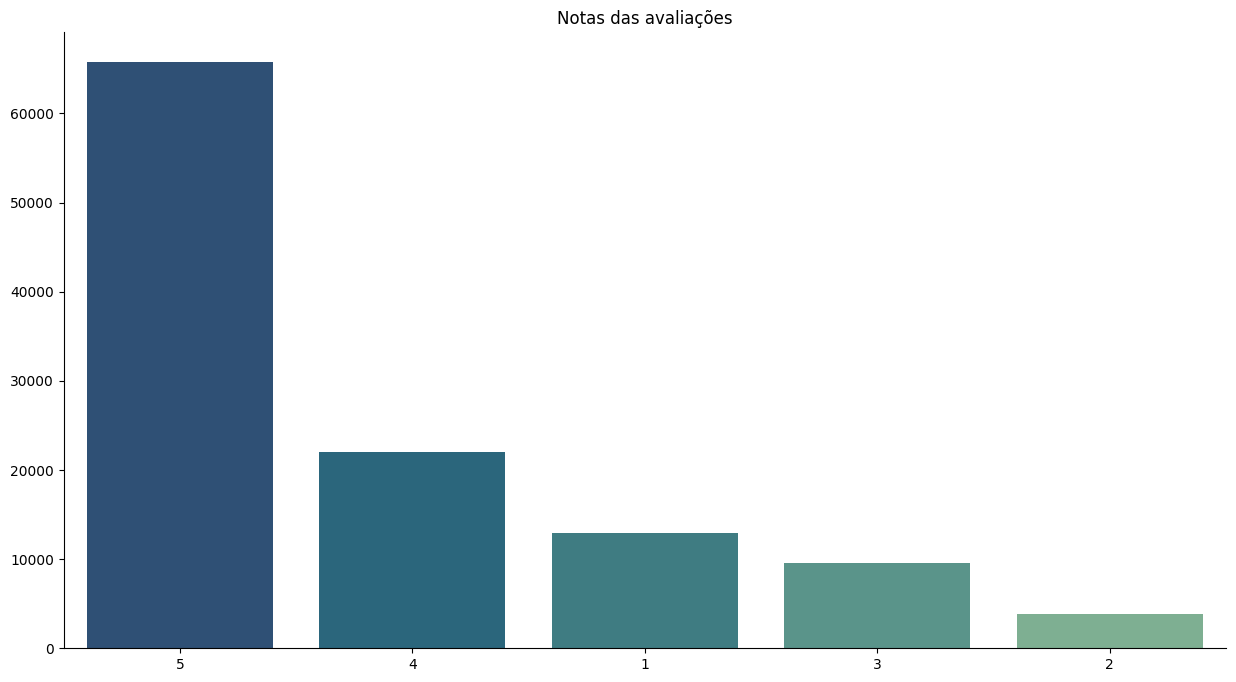

In [87]:
plt.figure(figsize=[15, 8])
review_score_index = [str(i) for i in df.review_score.value_counts().index]
sns.barplot(x = review_score_index, y= df.review_score.value_counts().values, palette= 'crest_r')
plt.title('Notas das avaliações')
sns.despine()

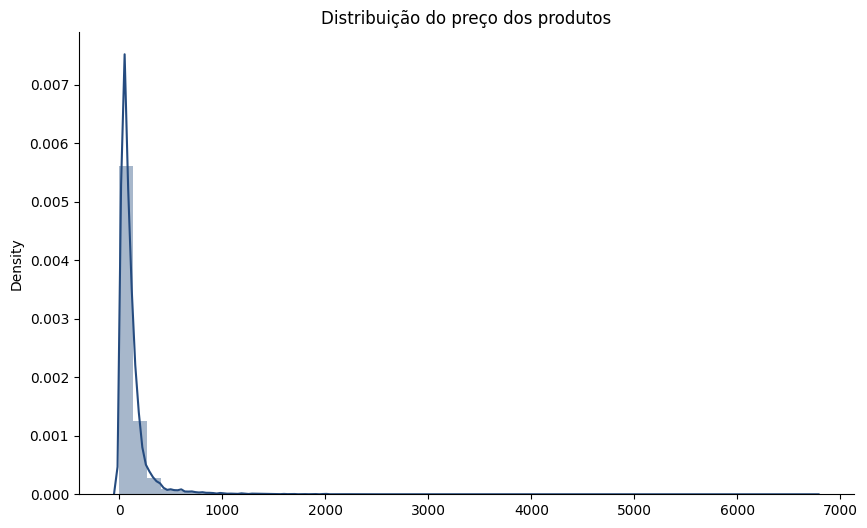

In [88]:
plt.figure(figsize=[10, 6])
sns.set_palette('crest_r')
sns.distplot(x = df.price)
plt.title('Distribuição do preço dos produtos')
sns.despine()

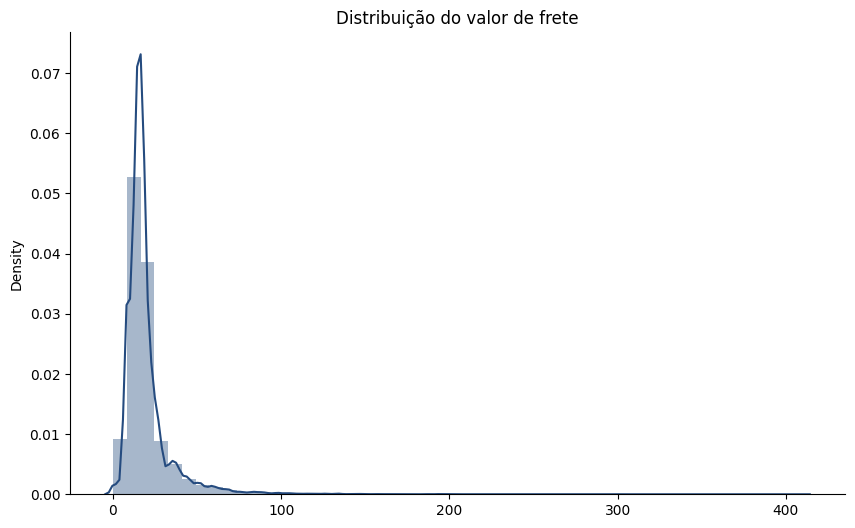

In [89]:
plt.figure(figsize=[10, 6])
sns.set_palette('crest_r')
sns.distplot(x = df.freight_value)
plt.title('Distribuição do valor de frete')
sns.despine()

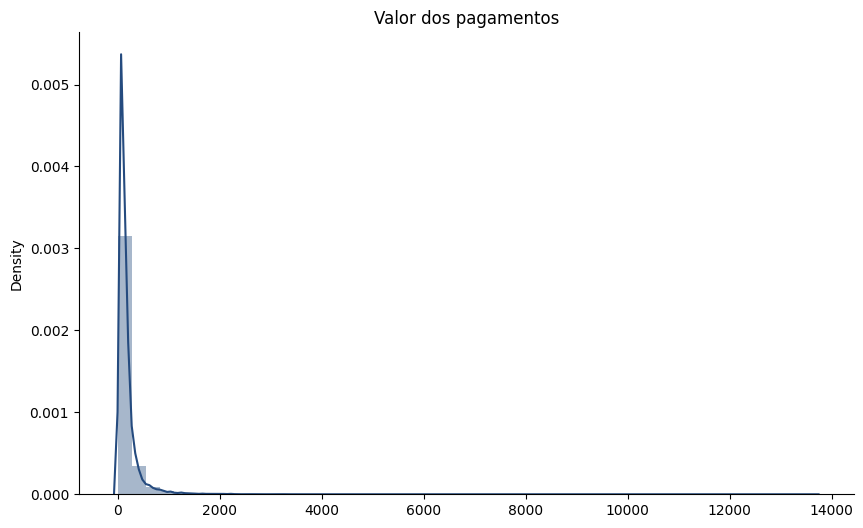

In [90]:
plt.figure(figsize=[10, 6])
sns.distplot(x = df.payment_value)
plt.title('Valor dos pagamentos')
sns.despine()

([<matplotlib.patches.Wedge at 0x1131e3aac90>,
 [Text(-0.8432110550112143, -0.781981532203207, 'credit_card'),
  Text(0.9893962218150933, 0.5861698697971595, 'boleto'),
  Text(0.29373613214545796, 1.1118538953802457, 'voucher'),
  Text(0.052186739569371, 1.1488152785426904, 'debit_card')],
 [Text(-0.4765975528324254, -0.4419895616800735, '73.8%'),
  Text(0.5592239514607049, 0.3313134046679596, '19.4%'),
  Text(0.16602477034308494, 0.6284391582583996, '5.3%'),
  Text(0.029496852800079257, 0.6493303748284771, '1.4%')])

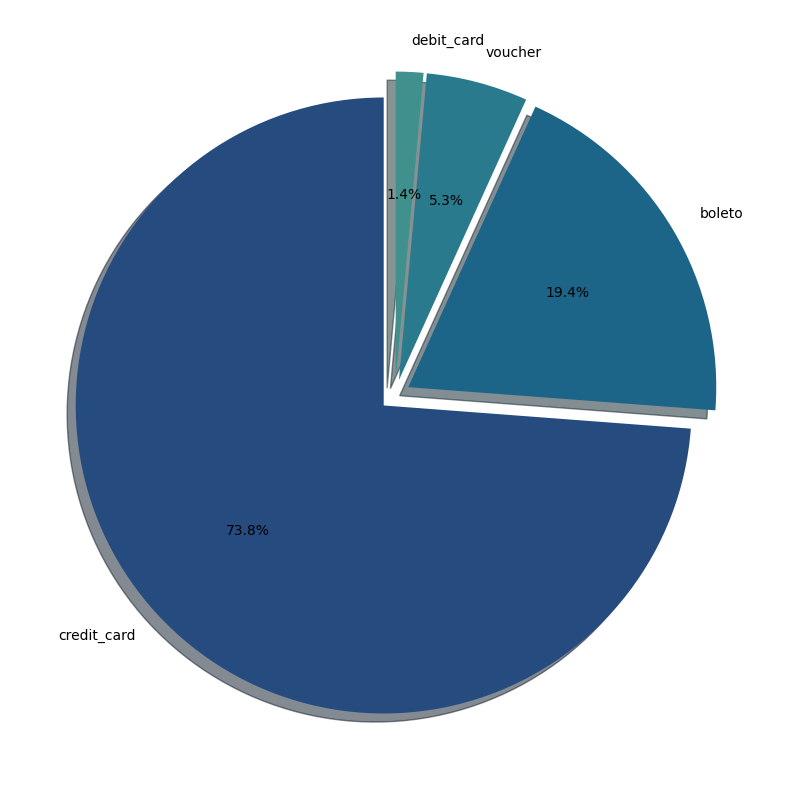

In [91]:
plt.figure(figsize=[10, 10])
plt.pie(df.payment_type.value_counts().values, explode=(0.05, 0.05, 0.05, 0.05), labels= df.payment_type.value_counts().index, autopct='%1.1f%%',shadow=True, startangle=90)

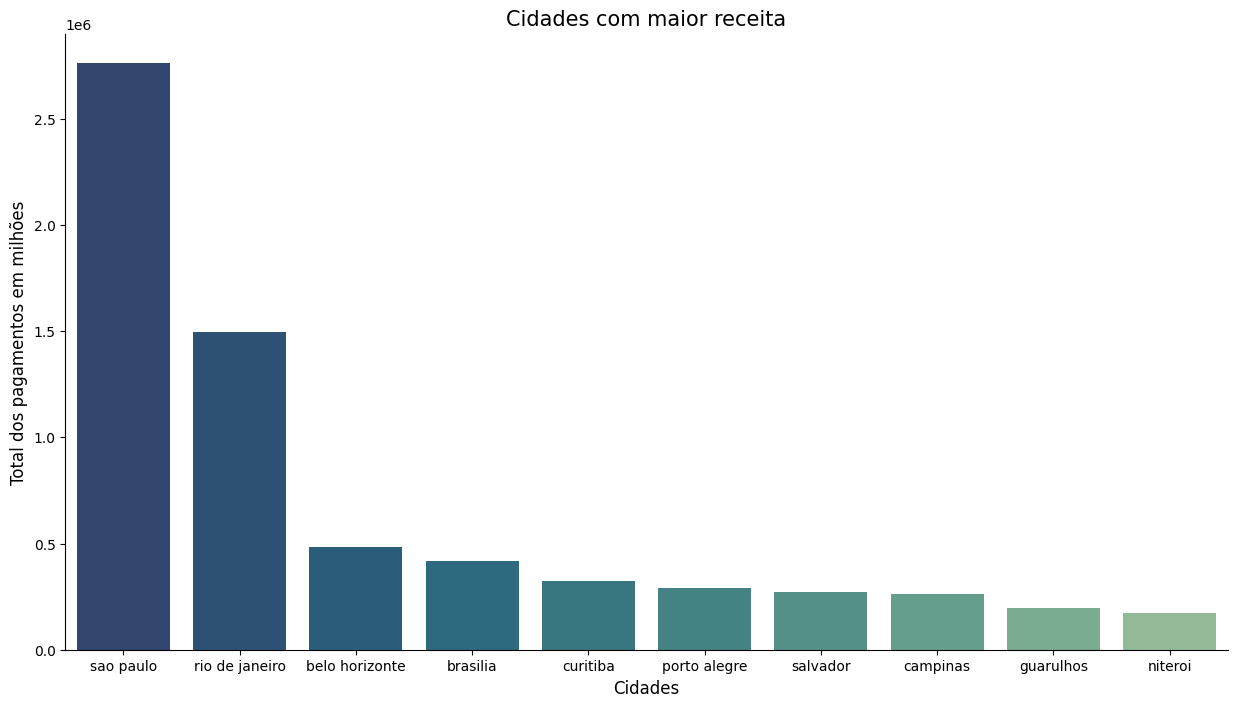

In [92]:
revenue_per_city = df.groupby('customer_city')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
revenue_per_city.reset_index(inplace=True)
plt.figure(figsize=[15, 8])
sns.barplot(x = revenue_per_city.customer_city[:10], y= revenue_per_city.payment_value[:10], palette= 'crest_r')
plt.title('Cidades com maior receita', fontsize= 15)
plt.xlabel('Cidades', fontsize= 12)
plt.ylabel('Total dos pagamentos em milhões',fontsize= 12)
sns.despine()

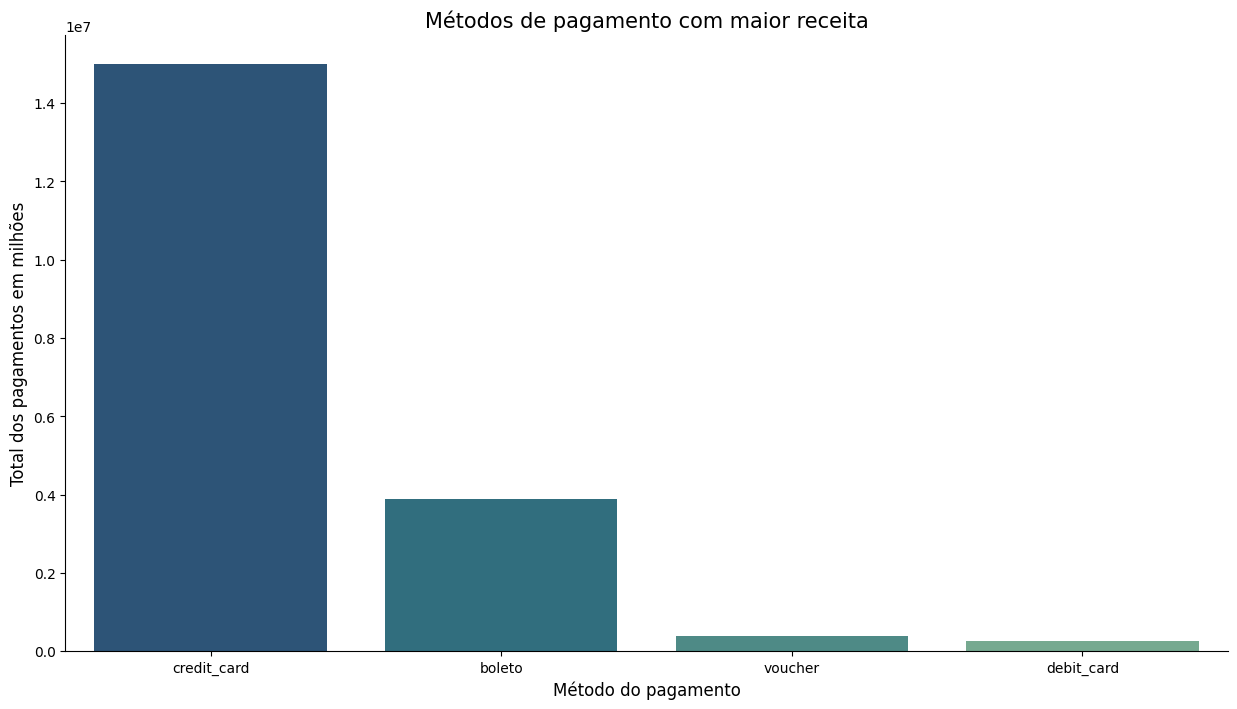

In [93]:
payment_methods = df.groupby('payment_type')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value, palette= 'crest_r')
plt.title('Métodos de pagamento com maior receita', fontsize= 15)
plt.xlabel('Método do pagamento', fontsize= 12)
plt.ylabel('Total dos pagamentos em milhões', fontsize= 12)
sns.despine()

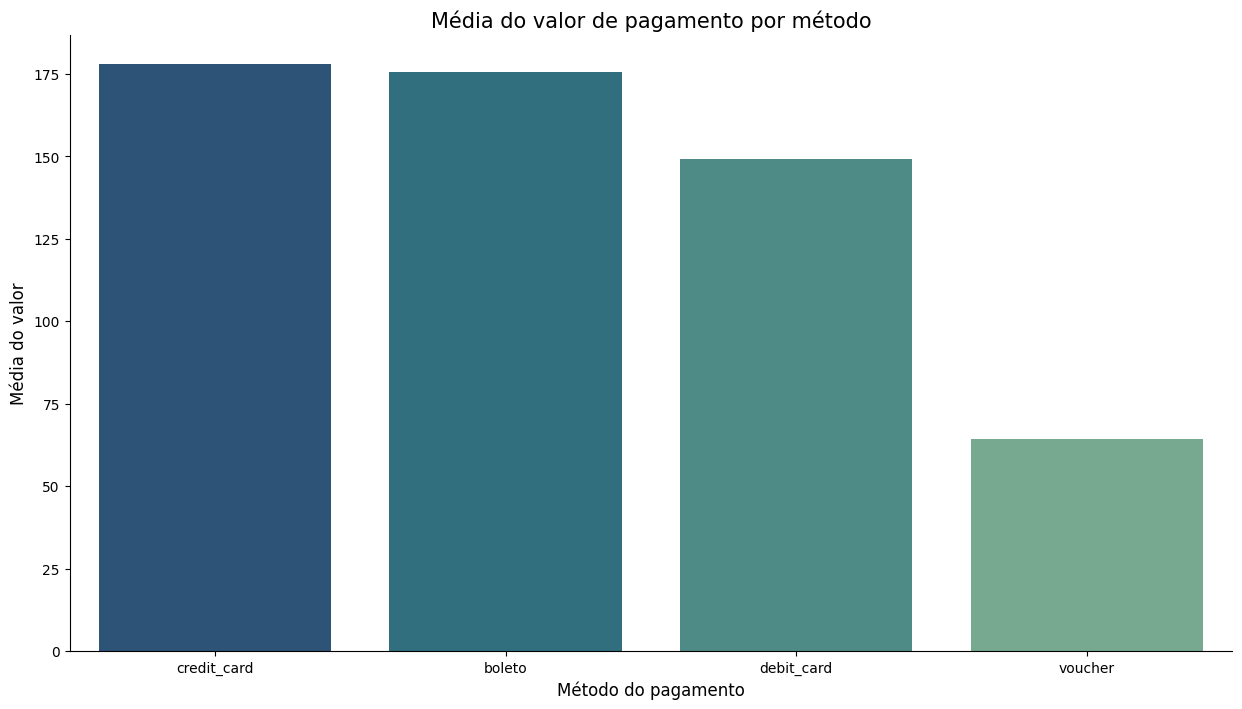

In [94]:
payment_methods = df.groupby('payment_type')[['payment_value']].mean().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value, palette= 'crest_r')
plt.title('Média do valor de pagamento por método', fontsize= 15)
plt.xlabel('Método do pagamento', fontsize= 12)
plt.ylabel('Média do valor', fontsize= 12)
sns.despine()

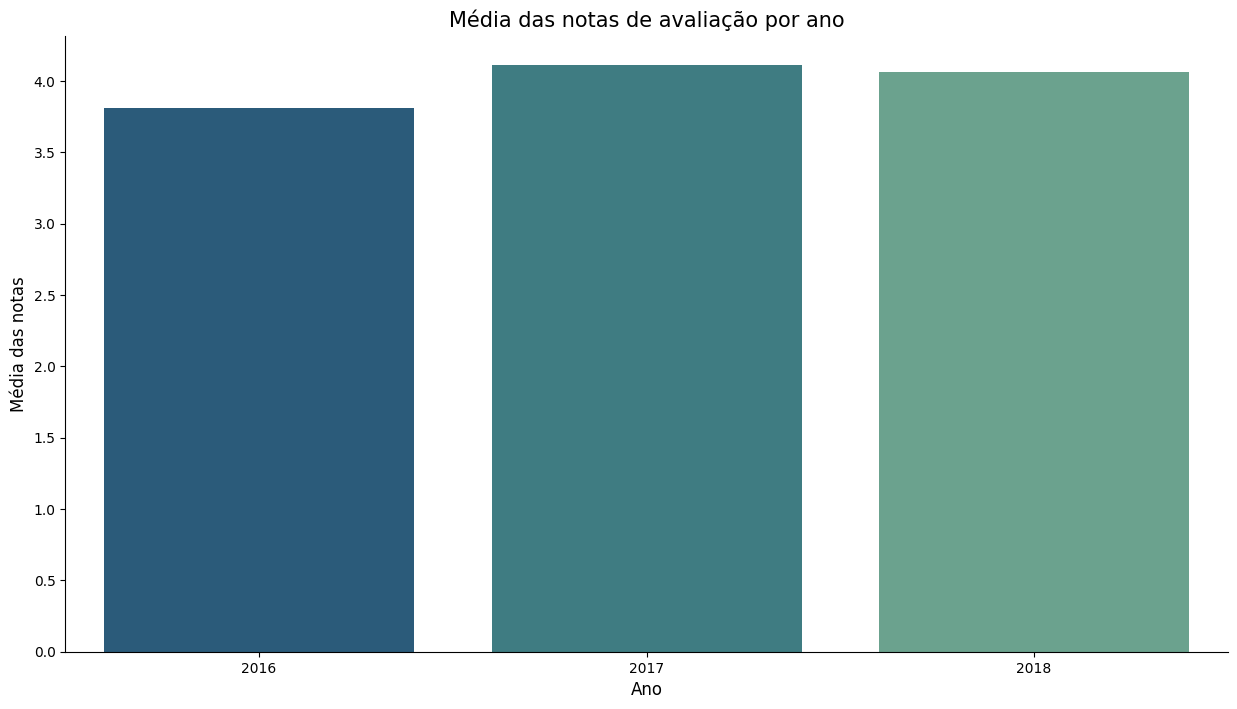

In [95]:
scorevstime = df.groupby(df['order_purchase_timestamp'].dt.year)['review_score'].mean().dropna()
plt.figure(figsize=[15, 8])
sns.barplot(x = scorevstime.index, y= scorevstime.values, palette= 'crest_r')
plt.title('Média das notas de avaliação por ano', fontsize= 15)
plt.xlabel('Ano', fontsize= 12)
plt.ylabel('Média das notas', fontsize= 12)
sns.despine()

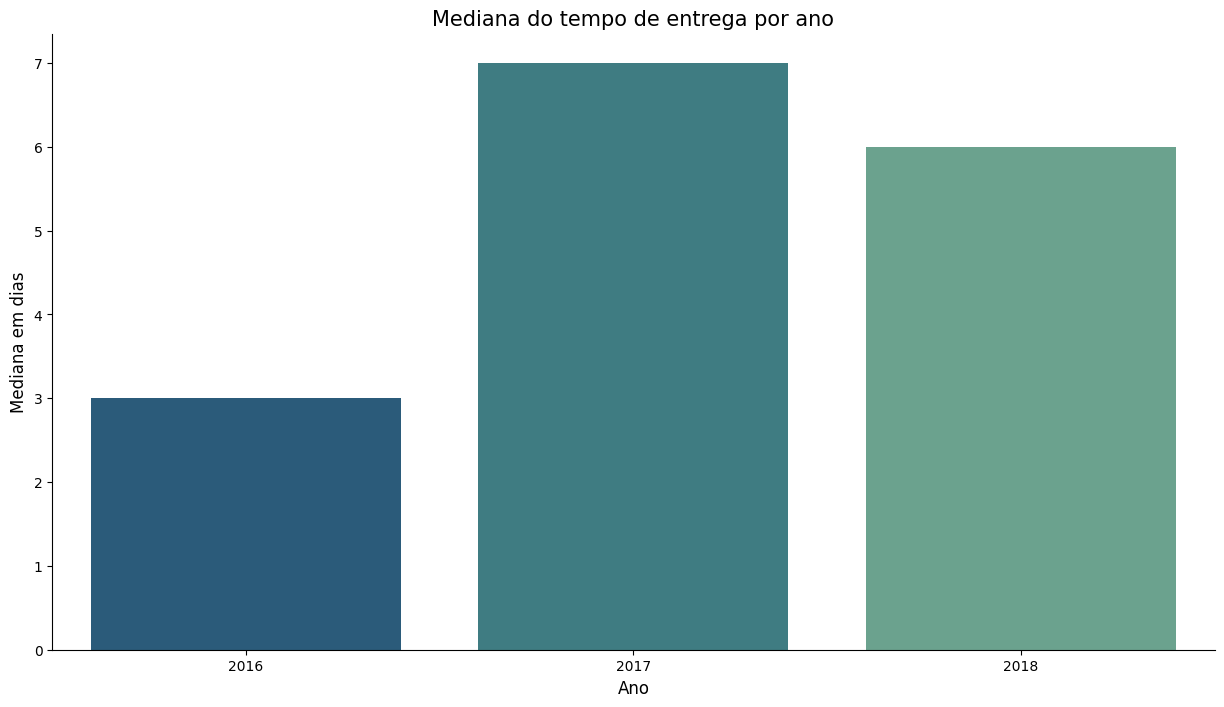

In [96]:
deliverytimevstime = df.groupby(df['order_purchase_timestamp'].dt.year)['shipping_days'].median()
plt.figure(figsize=[15, 8])
sns.barplot(x = deliverytimevstime.index, y= deliverytimevstime.values, palette= 'crest_r')
plt.title('Mediana do tempo de entrega por ano', fontsize= 15)
plt.xlabel('Ano', fontsize= 12)
plt.ylabel('Mediana em dias', fontsize= 12)
sns.despine()

<Axes: xlabel='review_score', ylabel='shipping_days'>

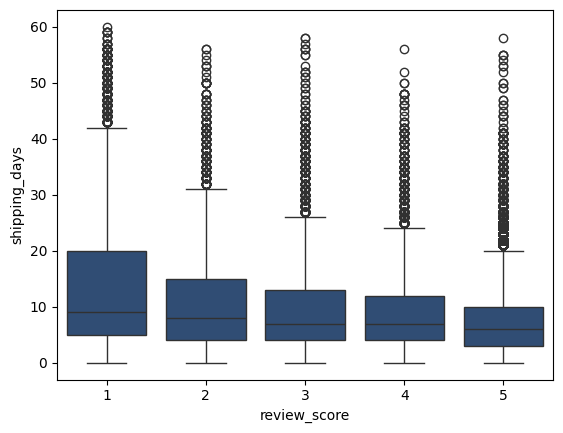

In [97]:
sns.boxplot(x='review_score', y='shipping_days', data=df)

<Axes: xlabel='review_score', ylabel='shipping_days'>

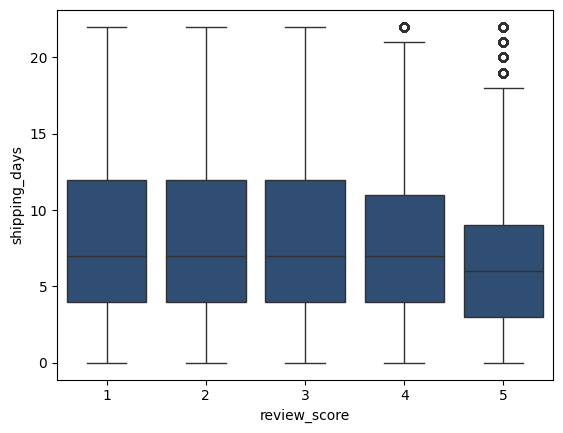

In [98]:
q_high = df['shipping_days'].quantile(0.95)
data_no_outliers = df[df['shipping_days'] < q_high]
sns.boxplot(x='review_score', y='shipping_days', data=data_no_outliers)

Conclusões:

- A maioria das avaliações recebe notas altas (4 e 5), indicando um alto nível de satisfação dos clientes.
- Os valores dos pagamentos e dos produtos apresentam distribuição assimétrica para a esquerda, enquanto o frete se assemelha mais a uma distribuição simétrica.
- Mais de 90% das compras são realizadas com cartão de crédito e boleto, gerando a maior parte da receita.
- Grandes capitais contribuem significativamente para a receita do negócio.
- Cartão de crédito, boleto e cartão de débito têm médias de valores de pagamento semelhantes.
- As notas de avaliações aumentaram ao longo dos anos.
- O tempo de entrega teve um aumento entre 2016 e 2017, seguido por uma diminuição entre 2017 e 2018.
- As avaliações tendem a ser mais positivas quando o tempo de entrega é menor.

### Implementando XGBoost para classificação de satisfação do cliente

Vamos começar removendo todas as informações que não serão úteis para o nosso modelo.

In [99]:
df.drop(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_id', 'order_purchase_timestamp',
        'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date',
        'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
        'order_item_id', 'product_id', 'seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'shipping_limit_date', 'product_category_name',
        'product_weight_g', 'product_name_lenght', 'order_status', 'payment_type'], axis= 1, inplace= True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114189 entries, 0 to 114188
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   review_score                114189 non-null  int64  
 1   price                       114189 non-null  float64
 2   freight_value               114189 non-null  float64
 3   product_description_lenght  112590 non-null  float64
 4   product_photos_qty          112590 non-null  float64
 5   product_length_cm           114189 non-null  float64
 6   product_height_cm           114189 non-null  float64
 7   product_width_cm            114189 non-null  float64
 8   payment_installments        114189 non-null  int64  
 9   payment_value               114189 non-null  float64
 10  estimated_days              114189 non-null  int64  
 11  arrival_days                114189 non-null  int64  
 12  shipping_days               114189 non-null  int64  
dtypes: float64(8),

<Axes: >

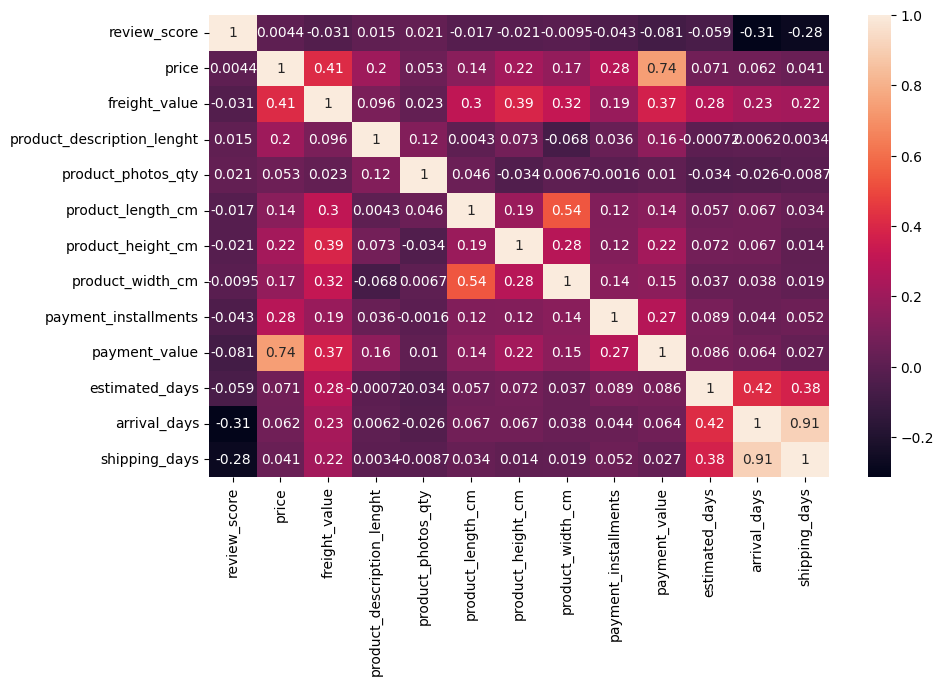

In [101]:
plt.figure(figsize= [10, 6])
sns.heatmap(df.corr(), annot= True)

Vamos remover as colunas com alta correlação para minimizar o *overfitting* no modelo.

In [102]:
df.drop(['shipping_days', 'price'], axis= 1, inplace= True)

In [103]:
df.head()

,review_score,freight_value,product_description_lenght,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,payment_installments,payment_value,estimated_days,arrival_days
0,4,21.88,1141.0,1.0,54.0,64.0,31.0,2,146.87,19,8
1,5,46.48,1002.0,3.0,89.0,15.0,40.0,8,335.48,24,16
2,5,17.79,955.0,1.0,52.0,52.0,17.0,7,157.73,24,26
3,5,23.36,1066.0,1.0,56.0,51.0,28.0,1,173.30,27,14
4,5,22.25,407.0,1.0,45.0,15.0,35.0,8,252.25,16,11


A variável target será a nota de avaliação, com as seguintes categorias:

- **Satisfeito ('Satisfied'):** Notas 4 e 5.
- **Não Satisfeito ('Not Satisfied'):** Notas abaixo de 4.

In [104]:
encoded_class = { 1 : 'Not Satisfied',
                  2 : 'Not Satisfied', 
                  3 : 'Not Satisfied', 
                  4 : 'Satisfied', 
                  5 : 'Satisfied'}

df['review_score'] = df['review_score'].map(encoded_class)

Remoção dos valores *NaN* restantes.

In [105]:
df.dropna(inplace= True)

Split do conjunto de treino e teste.

In [106]:
X = df.drop('review_score', axis=1)
y = df['review_score']

In [107]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42, stratify= y)

#### Seleção de Features

In [108]:
fs = SelectKBest(mutual_info_classif, k= 'all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

<Axes: >

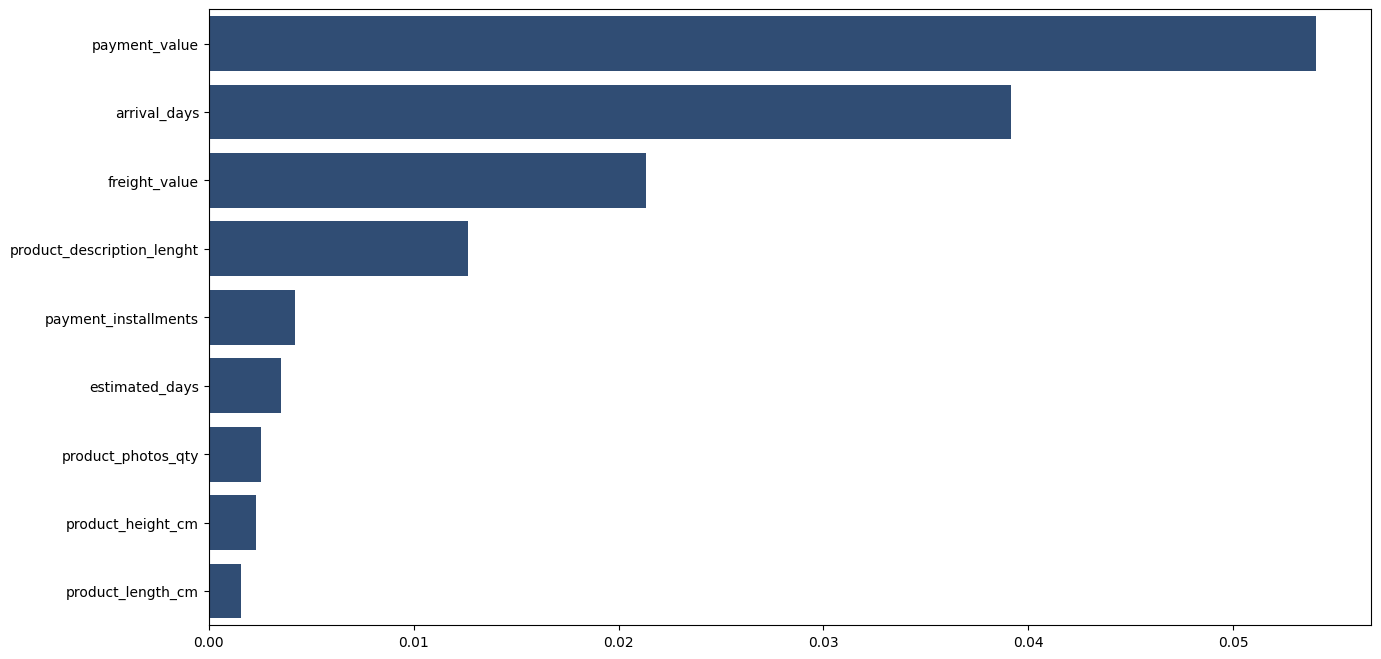

In [109]:
plt.figure(figsize=[15, 8])
indices = np.argsort(fs.scores_)[::-1]
features = []
for i in range(9):
    features.append(fs.feature_names_in_[indices[i]])
sns.barplot(x = fs.scores_[indices[range(9)]], y = features)

In [110]:
fs = SelectKBest(mutual_info_classif, k= 9)
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

In [111]:
x_train_fs = pd.DataFrame(x_train_fs, columns= fs.get_feature_names_out())
x_test_fs = pd.DataFrame(x_test_fs, columns= fs.get_feature_names_out())

#### Scaling das Features

In [112]:
sc = StandardScaler(with_mean= False)
x_train_scaled = sc.fit_transform(x_train_fs)
x_test_scaled = sc.transform(x_test_fs)

In [113]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns= sc.get_feature_names_out())
x_test_scaled = pd.DataFrame(x_test_scaled, columns= sc.get_feature_names_out())

### Balanceamento do Conjunto de Treino

In [114]:
round((y_train.value_counts() / y_train.shape[0]) * 100, 2)

review_score
Satisfied        76.98
Not Satisfied    23.02
Name: count, dtype: float64

Como podemos ver, o nosso conjunto de dados está bem desbalanceado, a fim de garantir uma melhor classificação, será utilizado a técnica SMOTE:

- SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de balanceamento de dados utilizada em problemas de classificação, especialmente em conjuntos de dados desbalanceados, onde uma classe é significativamente menor que a outra. O SMOTE funciona criando novas instâncias sintéticas da classe minoritária através da interpolação entre instâncias existentes. Essas novas instâncias são geradas ao calcular os vizinhos mais próximos das instâncias da classe minoritária e criar pontos intermediários. Isso ajuda a evitar o viés do modelo em direção à classe majoritária e melhora o desempenho da classificação para a classe minoritária.

In [115]:
smote = SMOTE(random_state= 42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

#### Implementação no XGBoost

XGBoost, ou Extreme Gradient Boosting, é uma poderosa técnica de aprendizado de máquina que se destaca em problemas de classificação e regressão. Funciona construindo uma série de árvores de decisão sequenciais, onde cada nova árvore tenta corrigir os erros dos modelos anteriores. Seu funcionamento acontece de forma:
- Árvores de Decisão: XGBoost usa árvores de decisão como base. Cada árvore é construída iterativamente, adicionando-a ao modelo para melhorar a previsão.
- Gradiente Descendente: XGBoost usa um método de otimização chamado "gradiente descendente" para minimizar uma função de perda. Ele ajusta os parâmetros do modelo na direção que reduz a perda, tornando as previsões mais precisas.
- Regularização: Para evitar overfitting (sobreajuste), XGBoost incorpora técnicas de regularização, como penalidades nos parâmetros das árvores e limitações na complexidade das árvores.
- Peso das Instâncias: XGBoost atribui pesos diferentes às instâncias durante o treinamento, priorizando aquelas que são mais difíceis de prever. Isso ajuda o modelo a se concentrar nas áreas onde precisa melhorar.
- Combinação de Árvores: XGBoost combina as previsões de todas as árvores para produzir uma única previsão final. Geralmente, essa combinação é feita através de uma média ponderada das previsões individuais.


![XGBoost](https://www.researchgate.net/publication/335483097/figure/fig3/AS:934217085100032@1599746118459/A-general-architecture-of-XGBoost.ppm)

CR de Treino 
               precision    recall  f1-score   support

           0       0.96      0.76      0.85     69338
           1       0.80      0.97      0.88     69338

    accuracy                           0.86    138676
   macro avg       0.88      0.86      0.86    138676
weighted avg       0.88      0.86      0.86    138676

CR de Teste 
               precision    recall  f1-score   support

           0       0.69      0.30      0.42      5183
           1       0.82      0.96      0.88     17335

    accuracy                           0.81     22518
   macro avg       0.75      0.63      0.65     22518
weighted avg       0.79      0.81      0.78     22518



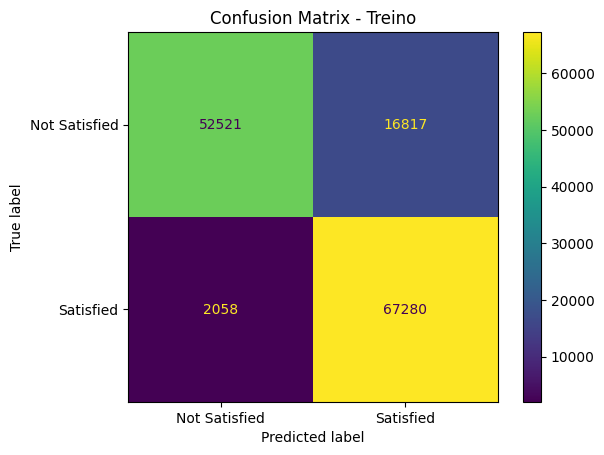

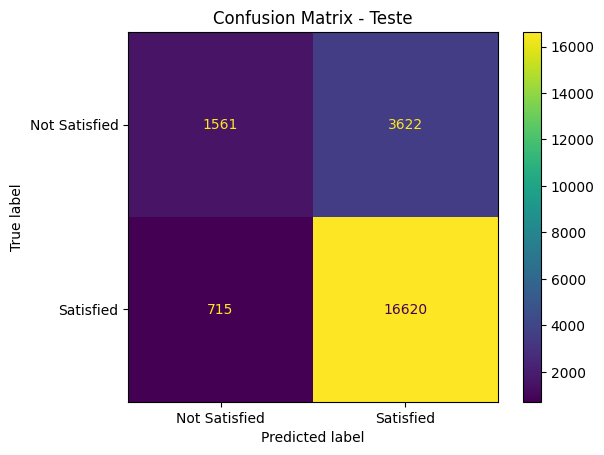

In [116]:
le = LabelEncoder()
y_train_xg = le.fit_transform(y_train_resampled)
y_test_xg = le.fit_transform(y_test)
xg = XGBClassifier()
xg.fit(x_train_resampled, y_train_xg)
print('CR de Treino \n', classification_report(y_train_xg, xg.predict(x_train_resampled)))
print('CR de Teste \n', classification_report(y_test_xg, xg.predict(x_test_scaled)))
cm_train = confusion_matrix(y_train_xg, xg.predict(x_train_resampled))
cm_test = confusion_matrix(y_test_xg, xg.predict(x_test_scaled))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=le.classes_)
disp_train.plot()
plt.title('Confusion Matrix - Treino')
plt.show()
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot()
plt.title('Confusion Matrix - Teste')
plt.show()

#### Ajuste de Hiperparâmetros com GridSearchCV

In [117]:
param_grid = {
   'learning_rate': [0.1, 0.2],
   'max_depth': [5, 7, 8],
   'n_estimators': [100, 200] 
   }
grid_search = GridSearchCV(xg, param_grid= param_grid, cv= 5, scoring= 'f1_macro')
grid_search.fit(x_train_resampled, y_train_xg)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 7, 8],
                         'n_estimators': [100, 200]},
             scoring='f1_macro')

CR de Treino 
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     69338
           1       0.85      0.99      0.92     69338

    accuracy                           0.91    138676
   macro avg       0.92      0.91      0.91    138676
weighted avg       0.92      0.91      0.91    138676

CR de Teste 
               precision    recall  f1-score   support

           0       0.75      0.35      0.47      5183
           1       0.83      0.97      0.89     17335

    accuracy                           0.82     22518
   macro avg       0.79      0.66      0.68     22518
weighted avg       0.81      0.82      0.80     22518



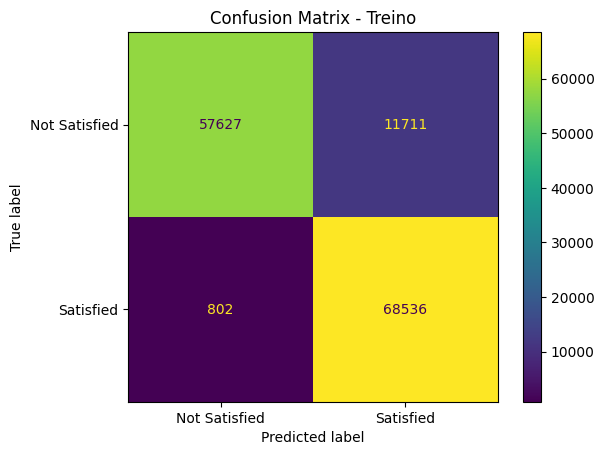

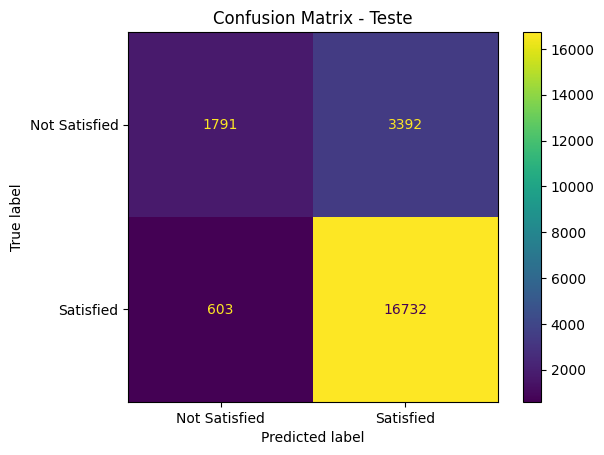

In [118]:
final_xg_model = XGBClassifier(learning_rate=0.2, max_depth=8, n_estimators=200)
final_xg_model.fit(x_train_resampled, y_train_xg)
print('CR de Treino \n', classification_report(y_train_xg, final_xg_model.predict(x_train_resampled)))
print('CR de Teste \n', classification_report(y_test_xg, final_xg_model.predict(x_test_scaled)))
cm_train = confusion_matrix(y_train_xg, final_xg_model.predict(x_train_resampled))
cm_test = confusion_matrix(y_test_xg, final_xg_model.predict(x_test_scaled))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=le.classes_)
disp_train.plot()
plt.title('Confusion Matrix - Treino')
plt.show()
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot()
plt.title('Confusion Matrix - Teste')
plt.show()

### Implementando Clusterização com K-Means usando RFM

RFM (Recency, Frequency, Monetary) é uma técnica de segmentação de clientes amplamente utilizada em marketing e análise de dados. Ela classifica os clientes com base em três principais métricas:

- Recência (Recency): Refere-se ao tempo desde a última interação ou transação do cliente com a empresa. Clientes recentes tendem a ser mais valiosos, pois estão mais engajados.
- Frequência (Frequency): Indica o número de interações ou transações que um cliente teve com a empresa durante um determinado período de tempo. Clientes frequentes geralmente representam uma base sólida para o negócio.
- Valor Monetário (Monetary): Representa o valor total gasto pelo cliente durante um período de tempo específico. Clientes com alto valor monetário são aqueles que contribuem significativamente para a receita da empresa.

Ao combinar essas três métricas, o RFM permite segmentar os clientes em diferentes grupos com base em seu comportamento de compra e interação com a empresa. Isso possibilita a personalização de estratégias de marketing e o direcionamento de esforços para clientes com maior potencial de retorno.

A seguir iremos calcular as medidas de RFM para cada cliente.

In [119]:
df_recency = df_copy.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'}, inplace=True)
df_recency['LastPurchaseDate'] = df_recency['LastPurchaseDate'].dt.date
recent_date = df_copy['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114
2,0000f46a3911fa3c0805444483337064,2017-03-10,537
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288


In [120]:
frequency_df = df_copy.groupby(['customer_unique_id']).agg({'order_id':'nunique'}).reset_index()
frequency_df.rename(columns={'order_id':'Frequency'}, inplace=True)
frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [121]:
monetary_df = df_copy.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [122]:
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [123]:
rfm_df[rfm_df.columns[1:]] = rfm_df[rfm_df.columns[1:]].applymap(lambda x: 1 if x ==0 else x)

#### Checando distribuições

In [124]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribuição de ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

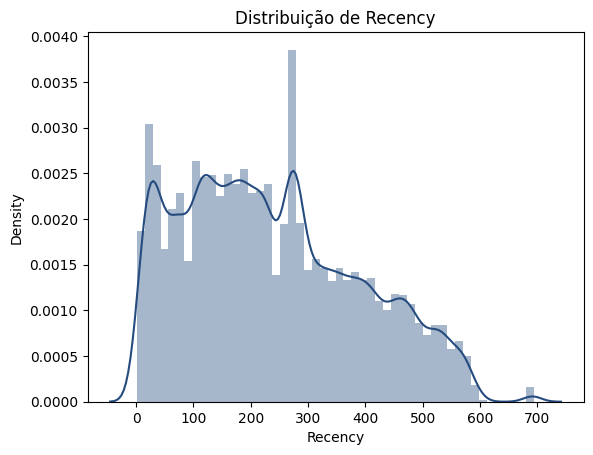

Recency's: Skew: 0.4422814517027352, : SkewtestResult(statistic=52.46728510687386, pvalue=0.0)


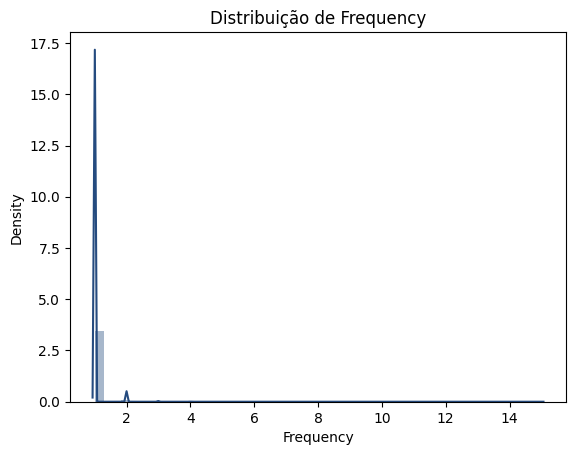

Frequency's: Skew: 11.258280186607852, : SkewtestResult(statistic=336.013286509977, pvalue=0.0)


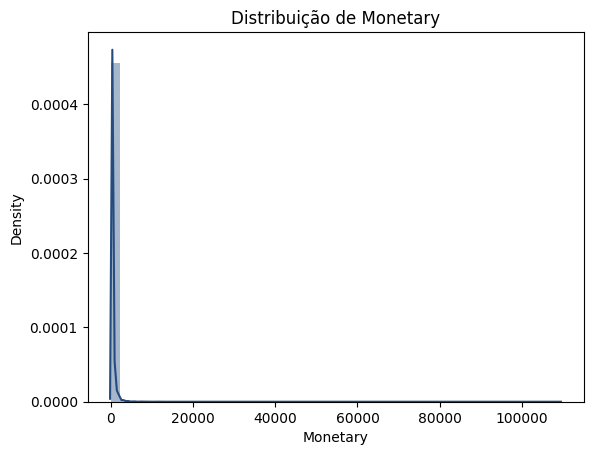

Monetary's: Skew: 71.40677612233601, : SkewtestResult(statistic=522.9484681272843, pvalue=0.0)


In [125]:
for col in rfm_df.columns[1:]:
    check_skew(rfm_df, col)

Podemos inferir que *Frequency* e *Monetary* apresentam uma distribuição assimétrica, devido seu valor de teste ser maior que 1. Portanto, iremos realizar uma transformação *logarítmica*, para garantir maior simetria no conjunto de dados.

In [126]:
rfm_df_log = rfm_df.copy()
for c in rfm_df.columns[2:]:
    rfm_df_log[c] = np.log10(rfm_df_log[c])

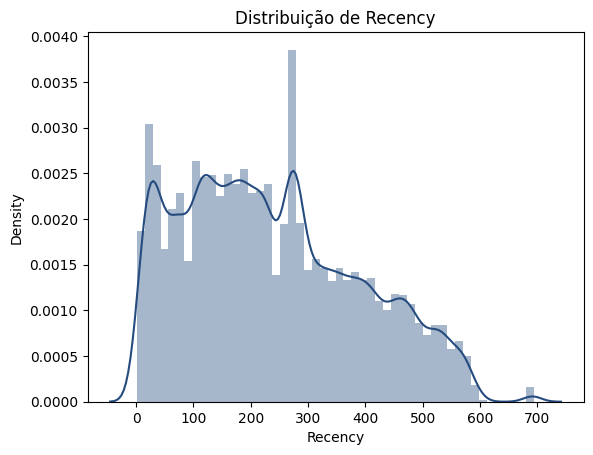

Recency's: Skew: 0.4422814517027352, : SkewtestResult(statistic=52.46728510687386, pvalue=0.0)


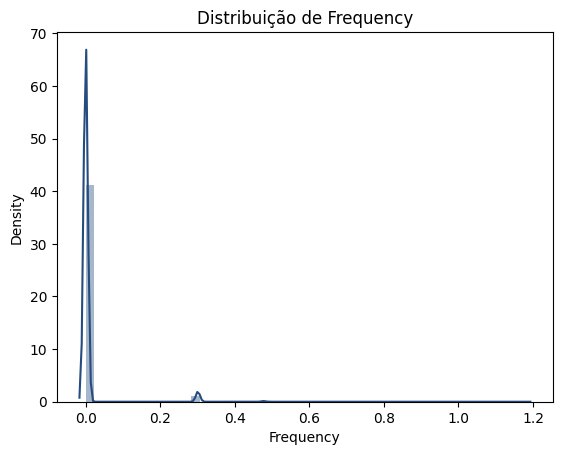

Frequency's: Skew: 6.132083964982573, : SkewtestResult(statistic=274.80115370984964, pvalue=0.0)


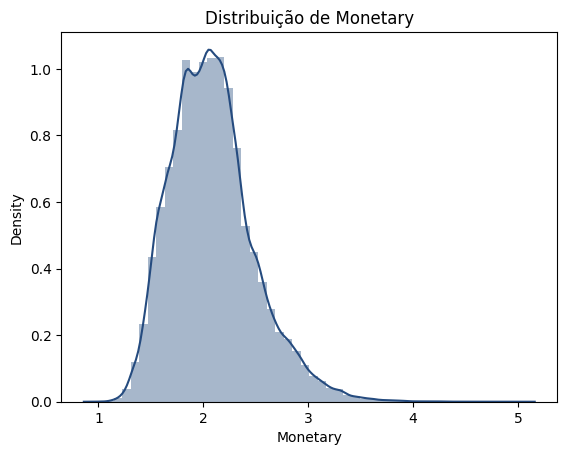

Monetary's: Skew: 0.7290323860505101, : SkewtestResult(statistic=81.3643201457947, pvalue=0.0)


In [127]:
for col in rfm_df.columns[1:]:
    check_skew(rfm_df_log, col)

#### Scaling das Features

In [128]:
scaler = StandardScaler()
scaler.fit(rfm_df_log.drop('customer_unique_id', axis=1))
RFM_Table_scaled = scaler.transform(rfm_df_log.drop('customer_unique_id', axis=1))
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=rfm_df_log.columns[1:])
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,-0.826465,-0.17117,0.170464
1,-0.806763,-0.17117,-1.635142
2,1.971185,-0.17117,-0.373992
3,0.552658,-0.17117,-1.118612
4,0.335939,-0.17117,0.528381


#### Descobrindo o K ideal

O método do cotovelo (Elbow Method) é uma técnica usada para determinar o número ideal de clusters em algoritmos de agrupamento. Este método ajuda a identificar o ponto onde a adição de mais clusters não resulta em uma melhora significativa na qualidade do agrupamento. Esse "ponto de cotovelo" indica o número ideal de clusters a ser escolhido.

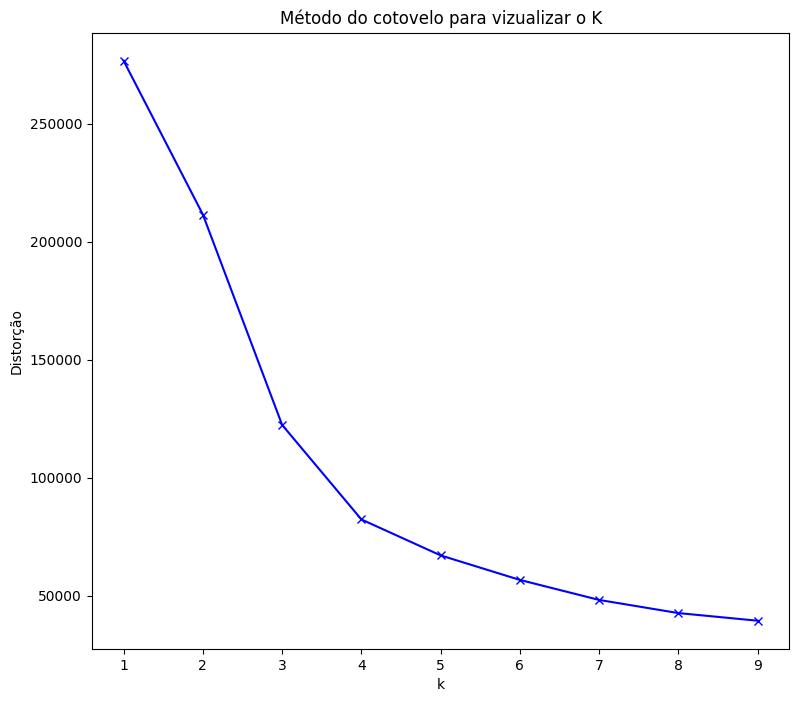

In [129]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_Table_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(9,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorção')
plt.title('Método do cotovelo para vizualizar o K')
plt.show()

O número de Clusters escolhido foi 4.

### Implementação no K-means

O K-means é um algoritmo de aprendizado não supervisionado usado para agrupar dados sem rótulos em clusters. Seu funcionamento acontece de forma:
- Inicialização: O algoritmo começa selecionando aleatoriamente K centroides, onde K é o número de clusters desejado.
- Atribuição de Cluster: Para cada ponto de dados, o algoritmo calcula a distância até cada centróide e atribui o ponto ao cluster representado pelo centróide mais próximo.
- Atualização do Centróide: Uma vez que todos os pontos foram atribuídos a um cluster, os centroides são recalculados como a média de todos os pontos no cluster. Isso move o centróide para uma posição melhor representativa do cluster.
- Reatribuição e Recálculo: Os passos 2 e 3 são repetidos iterativamente até que os centroides não mudem significativamente de posição ou até que um número máximo de iterações seja alcançado.
- Convergência: O algoritmo converge quando os centroides se estabilizam e a atribuição de pontos aos clusters não muda significativamente.
O resultado final é um conjunto de K clusters, onde cada ponto de dados foi atribuído ao cluster cujo centróide está mais próximo.

![KMeans](https://miro.medium.com/v2/resize:fit:1010/1*OFfN4I73rLPfhVqCcdcG5A.png)

In [130]:
kmean_model = KMeans(n_clusters=4, random_state=5)
kmean_y = kmean_model.fit_predict(RFM_Table_scaled)
rfm_df['Cluster'] = kmean_model.labels_

In [131]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(0)

    return df_new

### Avaliando Resultados

In [132]:
rfm_values(rfm_df)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         417.0       1.0    121.0  27599
1         191.0       1.0    519.0  22348
2         139.0       1.0     82.0  39570
3         219.0       2.0    486.0   2736

- **Cluster 0**: Designado como (Clientes Perdidos/Baixos Gastadores), este cluster caracteriza-se por ter uma das maiores recências entre os clientes, com um valor monetário baixo. Não é recomendado direcionar esforços de marketing para este cluster.

- **Cluster 1**: Este é o segundo melhor cluster (Grandes Gastadores), com uma boa recência, e com o maior Monetary, ou seja, com a média de gasto mais alta.

- **Cluster 2**: Este cluster pode ser entendido como (Novos Entrantes/Pequenos Gastadores), pois apresenta os menores gastos entre todos os clusters, acompanhados pela menor recência. Dado o seu tamanho considerável, seria aconselhável direcionar algum esforço de marketing para aumentar seu valor monetário.

- **Cluster 3**: Considerado o nosso melhor cluster (Clientes Fiéis), os clientes neste grupo podem não ter feito pedidos recentemente em média, mas têm uma frequência de pedidos maior do que todos os outros clusters, e o valor de seus pedidos é substancialmente alto.

### Conclusões

Com base nos resultados obtidos, podemos concluir que foi alcançada uma classificação satisfatória da satisfação dos clientes com uma precisão significativa. Além disso, a segmentação dos clientes com base na análise RFM foi bem-sucedida, o que abre caminho para melhorias substanciais no funcionamento do e-commerce.

Através da classificação da satisfação dos clientes, a empresa pode obter insights valiosos sobre as necessidades e preferências dos seus consumidores, além de identificar áreas de melhoria nos produtos ou serviços oferecidos.

Por meio da segmentação dos clientes utilizando a metodologia RFM (Recência, Frequência e Valor Monetário), a empresa pode direcionar suas ações de marketing de forma mais eficiente e personalizada. Essa abordagem permite identificar grupos de clientes com características semelhantes, facilitando a criação de campanhas direcionadas e mensagens mais relevantes. Além disso, a segmentação RFM pode ajudar a identificar clientes de alto valor que merecem atenção especial, bem como clientes em risco de perda que podem precisar de incentivos para continuar comprando.